Install package "arch" for estimation of GARCH model

In [1]:
# pip install arch 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from datetime import datetime
import scipy.stats as stats
import pylab 

# Data
Weekly price data of CAC40 of 25 years, from end of 1993 to end of 2018.

In [3]:
data = pd.read_csv('CAC40(1993-2018).csv')
cac = pd.DataFrame(data, columns = ['Date', 'Adj Close'])
cac['Date'] = pd.to_datetime(cac['Date'], format="%Y/%m/%d", errors='raise')
cac = cac.set_index('Date')

###### CAC40 price graph

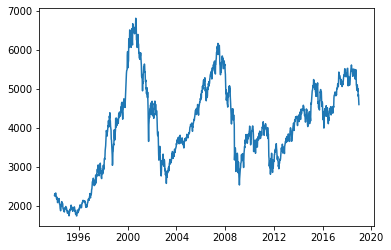

In [4]:
plt.plot(cac['Adj Close'])

plt.savefig("CAC40 price.png")

###### Calculate weekly losses

In [5]:
loss=-np.diff(cac['Adj Close'])/cac['Adj Close'][1:]
cac = cac[1:]
cac['Loss'] = loss

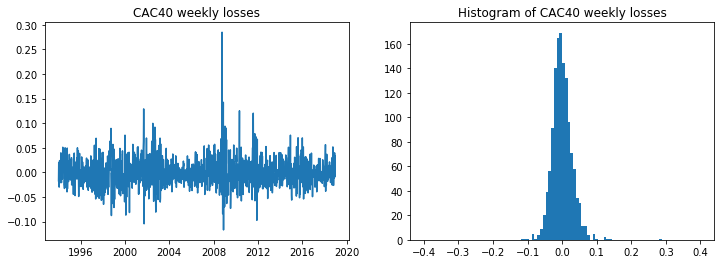

In [6]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 2)
plt.hist(loss, bins = 100, range = (-0.4,0.4))
plt.title('Histogram of CAC40 weekly losses')

plt.subplot(1, 2, 1)
plt.plot(loss)
plt.title('CAC40 weekly losses')

plt.savefig("CAC40 losses.png")

In [7]:
np.max(loss)

0.2846727088222305

In [8]:
print('Mean: ', np.mean(loss))
print('Standard deviation: ', np.sqrt(np.var(loss)))
print('Skewness: ',stats.skew(loss, bias=False))
print('Kurtosis: ',stats.kurtosis(loss, bias=False))

Mean:  -0.00011646317869102561
Standard deviation:  0.029407423422836438
Skewness:  1.031602308995891
Kurtosis:  7.833714632294047


###### Test of normality for weekly losses

In [9]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(loss, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,27.236122,0.002389


In [10]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(loss)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.323148
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


We see the weekly losses of CAC40 does not follow normal distribution, the high kurtosis show us the heavy tail distribution. We consider here GARCH(1,1) for modeling weekly losses of CAC40.

# GARCH(1,1) for weekly losses
The financial risk usually has a heavy tail distribution. Then we consider here the random term of GARCH(1,1) following Student distrubution, which show this characteristic better Normal distribution.

In [11]:
am = arch_model(loss*100, dist='StudentsT')
res = am.fit(update_freq=5)
resi = res.resid
res

Iteration:      5,   Func. Count:     46,   Neg. LLF: 3112.4430667146466
Iteration:     10,   Func. Count:     85,   Neg. LLF: 3109.511200714127
Iteration:     15,   Func. Count:    120,   Neg. LLF: 3109.204204480674
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3109.2042034050046
            Iterations: 16
            Function evaluations: 127
            Gradient evaluations: 16


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    Adj Close   R-squared:                      -0.002
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                            GARCH   Log-Likelihood:               -3109.20
Distribution:      Standardized Student's t   AIC:                           6228.41
Method:                  Maximum Likelihood   BIC:                           6254.27
                                              No. Observations:                 1304
Date:                      Mon, Feb 08 2021   Df Residuals:                     1299
Time:                              11:49:21   Df Model:                            5
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

In [12]:
np.min(resi)

-11.540250081796259

###### Saving the estimated parameters of GARCH model

In [13]:
mu, omega, alpha, beta = res.params[0:4]
sigma0 = res.conditional_volatility[-1] #the estimated volatility of the last week

###### Analysing the distribution of the random terms of GARCH(1,1)

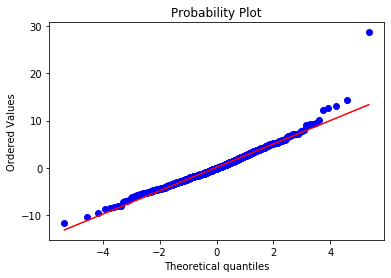

In [14]:
stats.probplot(resi, dist=stats.t, sparams=(7,), plot=pylab)
pylab.show()

#### We consider the large values of random term which maybe cause the failure of CPPI strategy, and use Pareto distribution for modeling them.

In [15]:
z = np.array(resi[resi>0])
z_max = np.max(z)

In [16]:
#Function returns mean excess value
def mean_excess(z):
    N = z.shape[0]
    z_sorted = np.array(sorted(z))
    me = np.zeros(N-1)
    for i in range(N-1):
        u = z_sorted[i]
        idx = z_sorted>u
        me[i] = sum(z_sorted*idx)/sum(idx) - u
    return me

In [17]:
#Function returns value of epsilon of Pareto's distribution 
def epsilon_pareto(z):
    N = z.shape[0]
    z_sorted = np.array(sorted(z))
    alpha = np.zeros(N-1)
    for i in range(N-1):
        u = z_sorted[i]
        idx = z_sorted>u
        alpha[i] = sum(idx)/sum(idx*(np.log(z_sorted/u)))
    return alpha

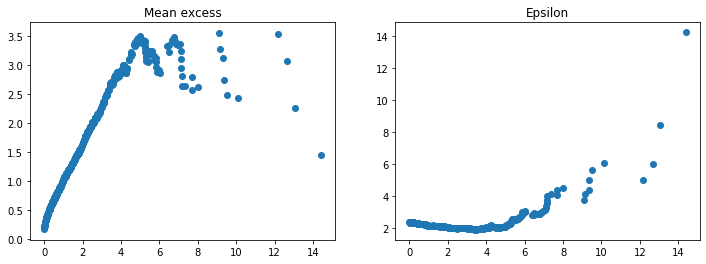

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(sorted(z)[:-1], epsilon_pareto(z))
plt.title('Mean excess')
plt.subplot(1, 2, 2)
plt.scatter(sorted(z)[:-1], mean_excess(z))
plt.title('Epsilon')
plt.savefig("mean excess.png")

In [19]:
u = np.array(sorted(z))[553]
eps = epsilon_pareto(z)[553]
print(u, eps)

4.503335105168485 3.226063199452561


#### From 2 graphs above, we choose the threshold for Pareto distribution u = 4.5%, and the correspond value of epsilon ~ 3.226. We check the suitability of this threshold.
Firstly, we plot the empirical distribution and theorical distribution.

In [37]:
def ecdf_GPD(z, u, epsilon):
    z_sorted = np.array(sorted(z))
    x = z_sorted[z_sorted>=u]
    n = x.size
    y1 = np.arange(1, n+1) / n
    y2 = 1-(x/u)**(-epsilon)
    fig, ax = plt.subplots()
    ax.plot(x,y1,label='Empirical')
    ax.plot(x,y2,label='Theorical')
    ax.set_title('Distribution of large innovation terms')
    ax.legend(bbox_to_anchor=(1, 0.2))
    return fig

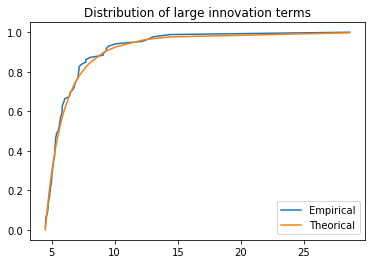

In [39]:
ecdf_GPD(z, u, eps)
plt.savefig("Tail distribution.png")

Using KS test for checking adequation of Pareto distribution 

In [22]:
from scipy.stats import ks_2samp
z_sorted = np.array(sorted(z))
x = z_sorted[z_sorted>=u]
n = x.size
y1 = np.arange(1, n+1) / n
y2 = 1-(x/u)**(-eps)

In [23]:
ks_2samp(y1, y2)

Ks_2sampResult(statistic=0.05813953488372093, pvalue=0.9988250932863276)

The result of the KS's test show us the Pareto distribution with the parameters we chose and calculated above is suitable for modeling the large random terms.

# Calculate the dynamique multiple CPPI

In [24]:
1/(-0.002+0.035*0.133)

376.64783427495286

In [25]:
N = len(loss)
N_u = sum(z>u)

#Function calculate the multiple for next period with the input the volatility of this period
def multiple(mu, sigma, N, N_u, u, epsilon, alpha):
    m = 1/(mu + sigma*u*((alpha*N/N_u)**(-1/epsilon)))
    return m

In [26]:
#Function calculate the allocation of portfolio V into non-risky asset M and risky asset E, with the multiple of CPPI "m". 
def allocation(V, N, T, t, rf, m):
    if V > N/(1+rf)**(T-t):
        P = N/(1+rf)**(T-t)
        E = m*(V - P)
        M = V-E
    else:
        E = 0
        M = V
    return E, M

In [27]:
#Function calculate the value of next period given the return of risky asset and non-risky asset
def port(E, M, r, rf):
    V = E*(1+r) + M*(1+rf)
    return V

In [28]:
#Function calculate the value of portfolio for T period
def multiple_CPPI(V0, N, rf, r, m):
    T= len(r)
    r = np.append([], r)
    m = np.append([], m)
    V = []
    V = np.append(V, V0)
    for t in range(T):
        E, M = allocation(V[t], N, T, t, rf, m[t])
        V = np.append(V, port(E, M, r[t], rf))    
    return V

# Applying on weekly data of CAC from end of 2018 to end of 2020

In [29]:
data1 = pd.read_csv('CAC40(2018-2020).csv')
cac1 = pd.DataFrame(data1, columns = ['Date', 'Adj Close'])
cac1['Date'] = pd.to_datetime(cac1['Date'], format="%Y/%m/%d", errors='raise')
cac1 = cac1.set_index('Date')
loss1=-np.diff(cac1['Adj Close'])/cac1['Adj Close'][1:]
cac1 = cac1[1:]
cac1['Loss'] = loss1

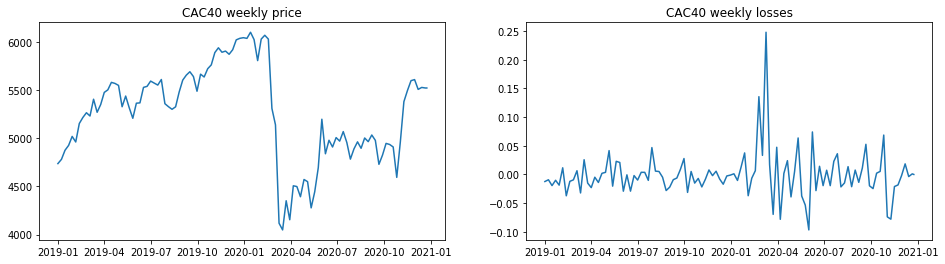

In [41]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(cac1['Adj Close'])
plt.title('CAC40 weekly price')

plt.subplot(1, 2, 2)
plt.plot(loss1)
plt.title('CAC40 weekly losses')

plt.savefig("CAC40 losses2020.png")

In [30]:
T = len(loss1)
mk = []
sigma = np.sqrt(omega + alpha*(loss[-1]*100)**2 + beta*sigma0**2)
for t in range(T):
    mk = np.append(mk, multiple(mu/100, sigma/100, N, N_u, u, eps, 1/100))
    sigma = np.sqrt(omega + alpha*(loss1[t]*100)**2 + beta*sigma**2)
cac1['Multiple'] = mk

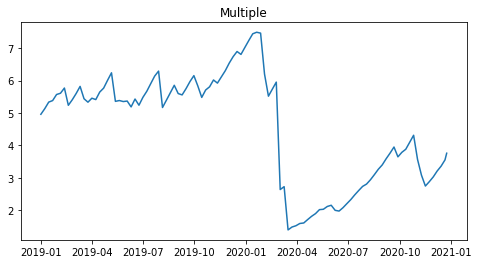

In [31]:
plt.figure(figsize=(8, 4))
plt.plot(cac1['Multiple'])
plt.title('Multiple')
plt.savefig("multiple.png")

In [32]:
np.max(loss1)

0.24785352275078731

In [42]:
V = multiple_CPPI(1000., 1020., 0.0003, -loss1, mk)
V1 = multiple_CPPI(1000., 1020., 0.0003, -loss1, 4*np.ones(len(loss1)))

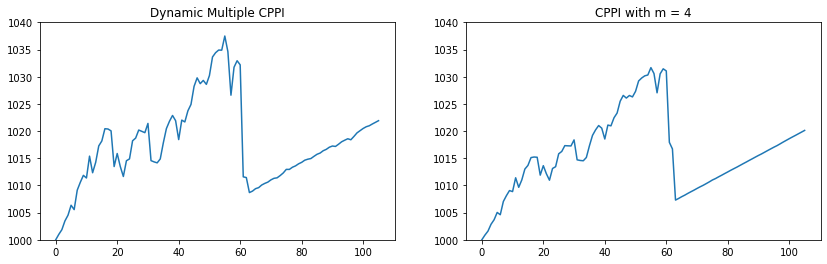

In [44]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(V)
plt.ylim((1000,1040))
plt.title('Dynamic Multiple CPPI')

plt.subplot(1, 2, 2)
plt.plot(V1)
plt.ylim((1000,1040))
plt.title('CPPI with m = 4')

plt.savefig("Value.png")